We used VADER but it did nto give good sentiment score. Hence, we decided to use FinBERT which is a finance-specific 
BERT-based model fine-tuned for sentiment analysis in financial texts.
Method:

    Tokenizing the text using BertTokenizer
    Passing it through the FinBERT model
    Extracting softmax probabilities
    Assigning sentiment based on the highest probability

In [1]:
# Getting Sentiment Score with VADER
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from transformers import BertTokenizer, BertForSequenceClassification
import time
import torch
from tqdm import tqdm
from torch.nn.functional import softmax
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load your cleaned data (ensure the CSV file path is correct)
df = pd.read_csv('/notebooks/finalversiondata.csv')
df.head()

Date                                               text Sentiment  \
0  2014-11-11  $37158 at 0015 utc 24h range $36028 $37158 vol...  Positive   
1  2014-12-05  live profit $63269 1544 buy b1101 $37050 sell ...  Positive   
2  2014-11-02  bitfinex prices last $32400 bid $32378 ask $32...  Positive   
3  2014-10-23  current price 2787 $btceur $btc 20141024 01000...  Negative   
4  2014-12-22  in the last 10 mins there were arb opps spanni...  Positive   

   year                                             tokens  \
0  2014  ['$', '37158', '0015', 'utc', '24h', 'range', ...   
1  2014  ['live', 'profit', '$', '63269', '1544', 'buy'...   
2  2014  ['bitfinex', 'prices', 'last', '$', '32400', '...   
3  2014  ['current', 'price', '2787', '$', 'btceur', '$...   
4  2014  ['last', '10', 'mins', 'arb', 'opps', 'spannin...   

                                            pos_tags  \
0  [('$', '$'), ('37158', 'CD'), ('0015', 'CD'), ...   
1  [('live', 'JJ'), ('profit', 'NN'), ('$', '$'),...   
2  [('bitfinex', 'NN'), ('prices', 'NNS'), ('last...   
3  [('current', 'JJ'), ('price', 'NN'), ('2787', ...   
4  [('last', 'JJ'), ('10', 'CD'), ('mins', 'NNS')...   

                                   lemmatized_tokens  \
0  ['$', '37158', '0015', 'utc', '24h', 'range', ...   
1  ['live', 'profit', '$', '63269', '1544', 'buy'...   
2  ['bitfinex', 'price', 'last', '$', '32400', 'b...   
3  ['current', 'price', '2787', '$', 'btceur', '$...   
4  ['last', '10', 'min', 'arb', 'opps', 'span', '...   

                                      stemmed_tokens  \
0  ['$', '37158', '0015', 'utc', '24h', 'rang', '...   
1  ['live', 'profit', '$', '63269', '1544', 'buy'...   
2  ['bitfinex', 'price', 'last', '$', '32400', 'b...   
3  ['current', 'price', '2787', '$', 'btceur', '$...   
4  ['last', '10', 'min', 'arb', 'opp', 'span', '2...   

                                        cleaned_text  
0  $ 37158 0015 utc 24h range $ 36028 $ 37158 vol...  
1  live profit $ 63269 1544 buy b1101 $ 37050 sel...  
2  bitfinex price last $ 32400 bid $ 32378 ask $ ...  
3  current price 2787 $ btceur $ btc 20141024 010...  
4  last 10 min arb opps span 24 exchange pair yie...

In [17]:
print(data['cleaned_text'].isnull().sum())
# SOME MISSING NAN FOUND LETS CLEARN DATA FUERTHER

3


In [6]:
# We need only date and clean_text column
df = df[["Date", "cleaned_text"]]

In [7]:
df = df.rename(columns={"cleaned_text": "text"})  # Rename 'cleaned_text' to 'text'


In [8]:
df.head()

Date                                               text
0  2014-11-11  $ 37158 0015 utc 24h range $ 36028 $ 37158 vol...
1  2014-12-05  live profit $ 63269 1544 buy b1101 $ 37050 sel...
2  2014-11-02  bitfinex price last $ 32400 bid $ 32378 ask $ ...
3  2014-10-23  current price 2787 $ btceur $ btc 20141024 010...
4  2014-12-22  last 10 min arb opps span 24 exchange pair yie...

In [9]:
# ✅ Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using device: {device}")  # Should print 'cuda'

# ✅ Load FinBERT Model & Move to GPU
model_name = "ProsusAI/finbert"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name).to(device)
model.eval()  # Set model to evaluation mode (faster inference)

# ✅ Load and Prepare Data
df = pd.read_csv('/notebooks/cleaned_data.csv')
df['text'] = df['text'].fillna('').astype(str)  # Ensure text is a string

# ✅ Batch Processing Function with % Tracking
def get_finbert_sentiment_score(texts, batch_size=32):
    """Process texts in batches with a single progress bar (1-100%)."""
    sentiment_scores = []
    total_batches = len(texts) // batch_size + (1 if len(texts) % batch_size != 0 else 0)

    for i in tqdm(range(0, len(texts), batch_size), desc="Processing Sentiment", unit="batch", ncols=80):
        batch_texts = texts[i:i + batch_size]  # Get batch
        
        inputs = tokenizer(batch_texts, return_tensors="pt", truncation=True, max_length=512, padding=True).to(device)
        
        with torch.no_grad():
            outputs = model(**inputs)

        probs = softmax(outputs.logits, dim=-1)
        P_negative = probs[:, 0].cpu().numpy()  # Extract Negative Probability
        P_positive = probs[:, 2].cpu().numpy()  # Extract Positive Probability
        
        # ✅ Compute Sentiment Score: P(positive) - P(negative)
        batch_scores = P_positive - P_negative
        sentiment_scores.extend(batch_scores)  # Append to final list
    
    return sentiment_scores

# ✅ Apply batch processing with a single progress bar
df['finbert_sentiment_score'] = get_finbert_sentiment_score(df['text'].tolist())

# ✅ Save Results
df.to_csv('/notebooks/Sentiment_With_FinBert.csv', index=False)
print("🚀 Sentiment analysis completed and saved with numerical scores!")


🚀 Using device: cuda


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Processing Sentiment: 100%|██████████████| 8339/8339 [07:06<00:00, 19.56batch/s]


🚀 Sentiment analysis completed and saved with numerical scores!


In [3]:
# We need only date and clean_text column
test_df = test_df[["Date","text" ,"sentiment_numeric"]]
test_df.tail()

Date                                               text  \
894  2017-12-08  nearly $64 million in bitcoin is missing follo...   
895  2015-04-02  $24651 at 1100 utc 24h range $24012 $24799 vol...   
896  2016-02-28  why donald trump and bitcoin are both unstoppa...   
897  2017-12-09  there are two kinds of bitcoin investors 1 idi...   
898  2018-07-31  updated chart $qkc lots of volume for analysis...   

     sentiment_numeric  
894               -1.0  
895                0.0  
896                1.0  
897               -1.0  
898                0.0

In [9]:
import pandas as pd
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score, classification_report

# Download the VADER lexicon (only needed once)
nltk.download("vader_lexicon")

# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Define a function to get sentiment label and compound score using VADER
def get_vader_sentiment(text):
    # If text is not a valid string or is empty, return Neutral sentiment
    if not isinstance(text, str) or text.strip() == "":
        return "Neutral", 0.0
    
    scores = sia.polarity_scores(text)
    compound = scores["compound"]
    
    # Use standard VADER thresholds to assign a label
    if compound >= 0.05:
        label = "Positive"
    elif compound <= -0.05:
        label = "Negative"
    else:
        label = "Neutral"
    
    return label, compound

# Load your test dataset (ensure it has 'text' and 'sentiment_numeric' columns)
# test_df = pd.read_csv('/notebooks/test_data.csv')

# Ensure the 'text' column contains valid strings
test_df['text'] = test_df['text'].fillna('').astype(str)

# Drop rows with missing ground truth sentiment_numeric values
test_df = test_df.dropna(subset=['sentiment_numeric'])

# Apply VADER sentiment analysis on the 'text' column
# This creates two new columns: one for the sentiment label and one for the compound score
test_df["VADER_Sentiment"], test_df["VADER_Score"] = zip(*test_df["text"].apply(get_vader_sentiment))

# Map VADER sentiment labels to numeric values:
# "Negative" -> -1.0, "Neutral" -> 0.0, "Positive" -> 1.0
label_to_numeric = {"Negative": -1.0, "Neutral": 0.0, "Positive": 1.0}
test_df["VADER_Sentiment_Numeric"] = test_df["VADER_Sentiment"].map(label_to_numeric)

# Evaluate the VADER predictions against the ground truth
true_numeric = test_df["sentiment_numeric"].tolist()
pred_numeric = test_df["VADER_Sentiment_Numeric"].tolist()

accuracy = accuracy_score(true_numeric, pred_numeric)
print("Accuracy (numeric):", accuracy)
print("\nClassification Report (numeric):")
print(classification_report(true_numeric, pred_numeric))


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Accuracy (numeric): 0.5133630289532294

Classification Report (numeric):
              precision    recall  f1-score   support

        -1.0       0.24      0.42      0.30        79
         0.0       0.66      0.59      0.62       511
         1.0       0.43      0.42      0.42       308

    accuracy                           0.51       898
   macro avg       0.44      0.47      0.45       898
weighted avg       0.54      0.51      0.52       898



In [8]:
# Load the processed dataset
df_FinBERT = pd.read_csv('/notebooks/Sentiment_With_FinBert.csv')

# Display first 10 rows
print(df_FinBERT.head(10))


                    datetime  \
0  2022-06-23 23:59:58+00:00   
1  2022-06-23 23:59:57+00:00   
2  2022-06-23 23:59:57+00:00   
3  2022-06-24 23:59:59+00:00   
4  2022-06-24 23:59:55+00:00   
5  2022-06-24 23:59:51+00:00   
6  2022-06-24 23:59:44+00:00   
7  2022-06-24 23:59:41+00:00   
8  2022-06-24 23:59:38+00:00   
9  2022-06-24 23:59:34+00:00   

                                                text  finbert_sentiment_score  
0                                bitcoin price index                 0.883552  
1          wow look nice good feeling drop dm collab                 0.697471  
2                            mean bitcoin might beat                 0.860198  
3                                bitcoin price index                 0.883552  
4                   nope bull run bitcoin 20 percent                 0.819879  
5                                          long live                 0.878117  
6  rev 3 gekkoscience newpac usb bitcoin miner 28...                 0.822068  
7  fun 

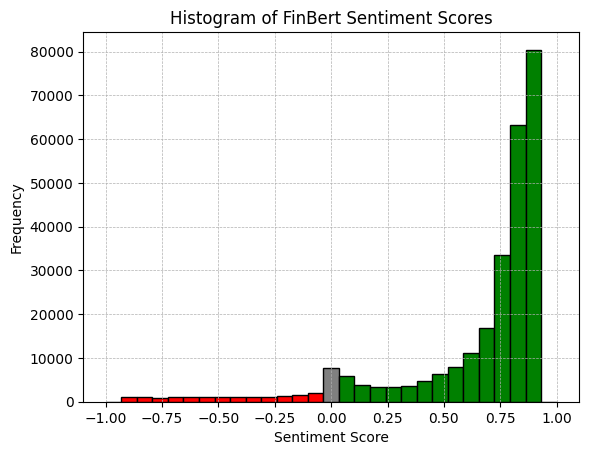

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Define your sentiment data and bins
data = df_FinBERT['finbert_sentiment_score']
bins = np.linspace(-1, 1, 30)  # Adjust the number of bins as needed

# Plot the histogram and capture the patches (bars)
counts, edges, patches = plt.hist(data, bins=bins, edgecolor='black')

# Colorize each bin based on its range:
for patch, left, right in zip(patches, edges[:-1], edges[1:]):
    if left < 0 and right > 0:
        patch.set_facecolor('grey')   # Neutral
    elif right <= 0:
        patch.set_facecolor('red')      # Negative
    else:
        patch.set_facecolor('green')    # Positive

# Add grid lines
plt.grid(True, linestyle='--', linewidth=0.5)

# Add labels and title
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Histogram of FinBert Sentiment Scores')
plt.show()
